## Решение

 * Добавить отслежевание точности. 
 * Увеличить к-во эпох обучения. хотябы до 200.

In [103]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import warnings # Не показывать предупреждения.
warnings.filterwarnings('ignore')

In [104]:
path_to_file = 'evgenyi_onegin.txt'

In [105]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# length of text is the number of characters in it
print('Length of text: {} characters'.format(len(text)))

Length of text: 286984 characters


In [106]:
print(text[:500])

Александр Сергеевич Пушкин

                                Евгений Онегин
                                Роман в стихах

                        Не мысля гордый свет забавить,
                        Вниманье дружбы возлюбя,
                        Хотел бы я тебе представить
                        Залог достойнее тебя,
                        Достойнее души прекрасной,
                        Святой исполненной мечты,
                        Поэзии живой и ясной,
                        Высо


In [107]:
text = text + text

In [108]:
# The unique characters in the file
#  Отсортируем все символы в датасете и удалим повтряющиеся. 
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

131 unique characters


In [109]:
# Creating a mapping from unique characters to indices
#  Сделаем перевод номеров симоволов в текст. 
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [110]:
text_as_int, text[:30], len(text_as_int), len(text)

(array([ 71, 110, 104, ..., 104, 121,   0]),
 'Александр Сергеевич Пушкин\n\n  ',
 573968,
 573968)

### train and target

In [111]:
# The maximum length sentence you want for a single input in characters

seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int) # ? Вот здесь не очень понятно. Зачем берут числа а не символы.

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

А
л
е
к
с


In [112]:
char_dataset.take(5)

<TakeDataset shapes: (), types: tf.int64>

In [113]:
# Выполним разбиение текста на последовательности длинной 100 символов.
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

# Выведем первые 5 батчей на экран.
for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'Александр Сергеевич Пушкин\n\n                                Евгений Онегин\n                          '
'      Роман в стихах\n\n                        Не мысля гордый свет забавить,\n                        '
'Вниманье дружбы возлюбя,\n                        Хотел бы я тебе представить\n                        '
'Залог достойнее тебя,\n                        Достойнее души прекрасной,\n                        Свят'
'ой исполненной мечты,\n                        Поэзии живой и ясной,\n                        Высоких д'


In [114]:
def split_input_target(chunk):
    input_text = chunk[:-1] # Предсказываем по одному символу.
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [115]:
dataset

# Разделим его на тренировочную и тестовую выборки.

<MapDataset shapes: ((100,), (100,)), types: (tf.int64, tf.int64)>

Print the first example input and target values:

In [116]:
for input_example, target_example in  dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'Александр Сергеевич Пушкин\n\n                                Евгений Онегин\n                         '
Target data: 'лександр Сергеевич Пушкин\n\n                                Евгений Онегин\n                          '


In [117]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).

BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [118]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 128

# Number of RNN units
rnn_units = 1024

In [119]:
class RNNgenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units): #, batch_size):
        super(RNNgenerator, self).__init__()
        
        self.emb = tf.keras.layers.Embedding(vocab_size, embedding_dim) #, batch_input_shape=[batch_size, None])
                                 
        self.gru1 = tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform')

        self.gru2 = tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform')
        self.gru3 = tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform')
        
        # self.lin_norm = tf.keras.layers.LayerNormalization()

        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, x):
        emb_x = self.emb(x)
        x = self.gru1(emb_x)
        x = self.gru2(x)
        x = self.gru3(x)

        x = self.dense(x)
        return x 

model = RNNgenerator(vocab_size,
                     embedding_dim,
                     rnn_units=rnn_units
                     ) #,
                    #  batch_size= BATCH_SIZE)
                     
# model.build(tf.TensorShape([1, None]))

In [120]:
# model.summary()

## Train the model

In [121]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# example_batch_loss = loss(target_example_batch, example_batch_predictions)
# print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
# print("scalar_loss:      ", example_batch_loss.numpy().mean())

In [122]:
model.compile(optimizer='adam', loss=loss, metrics='accuracy')

### Configure checkpoints

In [123]:
# Directory where the checkpoints will be saved
checkpoint_dir = './RNN_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_prefix,
                                save_freq=5,
                                save_weights_only=True)

### Execute the training

In [124]:
EPOCHS = 3

In [23]:
history = model.fit(dataset,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_callback]
                   )

Epoch 1/3
88/88 [==============================] - 87s 904ms/step - loss: 1.9452 - accuracy: 0.5616
Epoch 2/3
88/88 [==============================] - 81s 915ms/step - loss: 1.4290 - accuracy: 0.6062
Epoch 3/3
88/88 [==============================] - 80s 904ms/step - loss: 1.2909 - accuracy: 0.6317


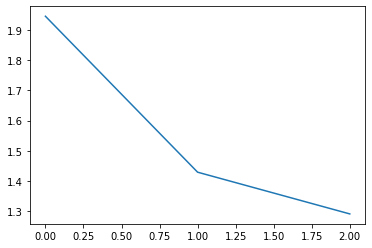

In [24]:
plt.plot(history.history['loss'])
plt.show()

## Generate text

In [25]:
tf.train.latest_checkpoint(checkpoint_dir)

'./RNN_checkpoints/ckpt_3'

In [26]:
# Востановим модель из кеша.

In [27]:
model = RNNgenerator(vocab_size, embedding_dim, rnn_units) #, batch_size=BATCH_SIZE)
# )
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [28]:
# model.summary()

## Генерация текста.

In [29]:
# Number of characters to generate
num_generate = 500

# Low temperature results in more predictable text.
# Higher temperature results in more surprising text.
# Experiment to find the best setting.
temperature = 1.0

In [30]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        
        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [31]:
text_ = generate_text(model, start_string=u"И вот идет уже ")
print(text_)

И вот идет уже ты
  мачцяж8ю    а СдибAX2loх,        шg6oсРyщяМpVuьлrй  В       Нtьл,
     ззхь:       В?
 дона          й, чвабзр}
 (Г37ай.
 Лfо
     бж5БT}
    ПФMомос):
                спz7nьто
  г     кой.
   Озимдбcкидпю      Зыхрr
   А
             о
          В            жяз    вли     ви
     Всмк        во
           Сей Т
  Iiожы
 Бd; п :
 Унs{1Лu!нычпу   жИ   о  Вб1кувц}
    А.   хдсмсжр8е;
  ЛVkьс-   вы       Ду   V,
   гй,
 Ре,        зт.
         р39масбе
  Дявой,
         с
 Iiунемд;
    Чь    


# Попробуем обучить модель с сохранением состояния.

In [132]:
class RNNgenerator_1(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) #, batch_input_shape=[batch_size, None])
    self.gru1 = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.gru2 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    self.gru3 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, x, states=None, return_state=False):

    x = self.embedding(x)

    if states is None:
      states = self.gru1.get_initial_state(x)

    x, states = self.gru1(x, initial_state=states)
    x, states = self.gru2(x, initial_state=states)
    x, states = self.gru3(x, initial_state=states)

    x = self.dense(x)

    if return_state:
      return x, states
    else:
      return x

In [133]:
# Directory where the checkpoints will be saved
checkpoint_dir = './RNN_1_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_prefix,
                                save_freq=1,
                                save_weights_only=True)

In [134]:
model_1 = RNNgenerator_1(
                 vocab_size= vocab_size,
                 embedding_dim=embedding_dim,
                
                 rnn_units=rnn_units,
                #  batch_size=BATCH_SIZE
                )

In [ ]:
# model_1.build(tf.TensorShape([1, None]))

In [135]:
model_1.compile(optimizer='adam', loss=loss, metrics='accuracy')

In [ ]:
# model_1.summary()

In [136]:
history = model_1.fit(dataset,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_callback])

Epoch 1/3
88/88 [==============================] - 245s 3s/step - loss: 2.0053 - accuracy: 0.5598
Epoch 2/3
88/88 [==============================] - 265s 3s/step - loss: 1.4750 - accuracy: 0.5994
Epoch 3/3
88/88 [==============================] - 258s 3s/step - loss: 1.3158 - accuracy: 0.6243


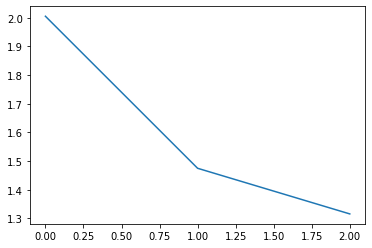

In [137]:
plt.plot(history.history['loss'])
plt.show()

## Генерация текста.

In [167]:
num_generate = 500
temperature = 1.0

In [ ]:
def generate_text(model, start_string, states):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions, states = model(input_eval, states=states, return_state=True)
        predictions = tf.squeeze(predictions, 0)
        
        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [175]:
class OneStep(tf.keras.Model):
  def __init__(self, model, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model

  # @tf.function
  def generate_one_step(self, inputs, states=None):
    # Converting our start string to numbers (vectorizing)
    input_chars = [char2idx[s] for s in inputs]
    input_ids = tf.expand_dims(input_chars, 0)

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(x=input_ids, states=states, return_state=True)
    predicted_logits = tf.squeeze(predicted_logits, 0)
    
    # using a categorical distribution to predict the character returned by the model
    predicted_logits = predicted_logits / temperature
    predicted_id = tf.random.categorical(predicted_logits, num_samples=1)[-1, 0].numpy()

    # Convert from token ids to characters
    predicted_chars = idx2char[predicted_id]

    # Return the characters and model state.
    return predicted_chars, states

In [168]:
states = None
next_char = u"И вот идет уже "
text_generated=[]

In [172]:
for n in range(100):
#   def generate_one_step(self, inputs, states=None):
    # Converting our start string to numbers (vectorizing)
    input_chars = [char2idx[s] for s in next_char]
    input_ids = tf.expand_dims(input_chars, 0)

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = model_1(x=input_ids, states=states, return_state=True)
    predicted_logits = tf.squeeze(predicted_logits, 0)
    
    # using a categorical distribution to predict the character returned by the model
    predicted_logits = predicted_logits / temperature
    predicted_id = tf.random.categorical(predicted_logits, num_samples=1)[-1, 0].numpy()

    # Convert from token ids to characters
    predicted_chars = idx2char[predicted_id]

    text_generated.append(idx2char[predicted_id])

    # Return the characters and model state.
    # return predicted_chars, states

In [173]:
text = ''.join(text_generated)
print(text)

и-бобшлснвшт-ШвсмпдгббсдлрвялжсдурпНлтстртнсдвширтшбжддмвнлбувеавчмтчг.эжрнспетдлбмФунссп,тдкссщбувплв


In [164]:
# model_1.reset_states()
one_step_model = OneStep(model_1, temperature)

In [176]:
states = None
next_char = u"И вот идет уже " # tf.constant([u"И вот идет уже "]) 
result = [next_char]

for n in range(1):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

text = ''.join(result)
print(text)

AttributeError: in user code:

    <ipython-input-98-ccfd8629181e>:24 generate_one_step  *
        predicted_id = tf.random.categorical(predicted_logits, num_samples=1)[-1, 0].numpy()
    /home/sergey/anaconda3/envs/imageai_env/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:401 __getattr__
        self.__getattribute__(name)

    AttributeError: 'Tensor' object has no attribute 'numpy'
